In [19]:
import numpy as np
import MDAnalysis as mda
from loguru import logger
import matplotlib.pyplot as plt
import prettypyplot as pplt
import lipyphilic as lpp

pplt.use_style(colors='tab20', latex=False, ipython=False,
               mode='print')

In [30]:
u = mda.Universe('/home/users/yuzhuang/Zhuang/MOR/simulations/MOR_apo_Gi/v1/rep1/skip2/system.pdb',
                 [f'/home/users/yuzhuang/Zhuang/MOR/simulations/MOR_apo_Gi/v1/rep{rep}/skip2/system.xtc' for rep in range(1, 13)])

/oak/stanford/groups/rondror/users/yuzhuang/software/mdanalysis/package/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


In [4]:
u = mda.Universe('test/abfe/equil/pose0/vac.pdb',
            ['test/abfe/equil/pose0/md-01.nc',
             #'test/abfe/equil/pose0/md-02.nc',
             #'test/abfe/equil/pose0/md-03.nc'
            ])

/oak/stanford/groups/rondror/users/yuzhuang/software/mdanalysis/package/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


In [31]:
from MDAnalysis.analysis.results import Results

class SystemValidator:
    def __init__(self, universe, ligand=None):
        self.universe = universe
        if ligand is not None:
            self.ligand = ligand
        else:
            self._guess_ligand()
        self.results = Results()
        self._validate()

    def _guess_ligand(self):
        ligand_ag = self.universe.select_atoms('not protein and not resname HOH TIP3 WAT DUM OL PA PC')
        possible_resnames = np.unique(ligand_ag.resnames)
        # ligand resname should be lower case
        possible_resnames = [resname for resname in possible_resnames if resname.islower()]
        if len(possible_resnames) == 1:
            self.ligand = possible_resnames[0]
            logger.info(f'Guessed ligand resname: {self.ligand}')
        if len(possible_resnames) == 0:
            self.ligand = 'XXX'
            logger.warning('No ligand is found. If you know the ligand resname, '
                           'set it by `ligand` argument')
        else:
            raise ValueError('Could not guess ligand resname. It may be '
                             f'one of {possible_resnames}, set it by `ligand` argument')
    def _validate(self):
        self._box()
        self._rmsd()
        self._rmsf()
        self._membrane()
    
    def _box(self):
        logger.info('Calculating box size')
        results = []
        for ts in self.universe.trajectory:
            box = ts.dimensions[:3]
            results.append(box)
        self.results['box'] = results

    def _rmsd(self):
        logger.info('Calculating RMSD')
        from MDAnalysis.analysis.rms import RMSD
        rms = RMSD(self.universe,
                   self.universe,
                   groupselections=[f'resname {self.ligand}'],
                   select='name CA').run()
        self.results['protein_rmsd'] = rms.results.rmsd.T[2]
        self.results['ligand_rmsd'] = rms.results.rmsd.T[3]
    
    def _rmsf(self):
        logger.info('Calculating RMSF')
        from MDAnalysis.analysis import rms, align
        u = self.universe
        average = align.AverageStructure(
                u,
                u,
                select='protein and name CA',
                ref_frame=0).run()

        ref = average.results.universe

        aligner = align.AlignTraj(u, ref,
                          select='protein and name CA',
                          in_memory=True).run()

        c_alphas = u.select_atoms('protein and name CA')
        R = rms.RMSF(c_alphas).run()

        self.results['ligand_rmsf'] = R.results.rmsf

    def _membrane(self):
        return
        logger.info('Calculating membrane properties')
        # Find which leaflet each lipid is in at each frame
        leaflets = lpp.AssignLeaflets(
            universe=self.universe,
            lipid_sel="resname OL PA PC"
            )

        leaflets.run()
        
        logger.info('Calculating leaflet areas')
        areas = lpp.analysis.AreaPerLipid(
            universe=self.universe,
            lipid_sel="resname OL PA PC",
            leaflets=leaflets.leaflets
            )

        areas.run()
        self.results['leaflet_areas'] = areas.areas

    def plot_box(self):
        logger.info('Plotting box size')
        box_results = np.array(self.results['box'])
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(box_results[:, 0], label='x')
        ax.plot(box_results[:, 1], label='y')
        ax.plot(box_results[:, 2], label='z')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Box size (nm)')
        ax.legend()
        plt.show()
    
    def plot_rmsd(self):
        logger.info('Plotting RMSD')
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(self.results['protein_rmsd'], label='Protein')
        ax.plot(self.results['ligand_rmsd'], label='Ligand')
        ax.set_xlabel('Frame')
        ax.set_ylabel('RMSD (nm)')
        ax.legend()
        plt.show()

    def plot_rmsf(self):
        logger.info('Plotting RMSF')
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(self.results['ligand_rmsf'], label='Ligand')
        ax.set_xlabel('Residue')
        ax.set_ylabel('RMSF (nm)')
        plt.show()
    
    def plot_lecaaflet_areas(self):
        logger.info('Plotting leaflet areas')
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        ax.plot(self.results['leaflet_areas'])
        ax.set_xlabel('Frame')
        ax.set_ylabel('Area per lipid (nm^2)')
        plt.show()

In [32]:
sys_validator = SystemValidator(u)

2025-01-10 15:20:52.519 | WARNING  | __main__:_guess_ligand:23 - No ligand is found. If you know the ligand resname, set it by `ligand` argument
2025-01-10 15:20:52.520 | INFO     | __main__:_box:35 - Calculating box size
2025-01-10 15:22:39.728 | INFO     | __main__:_rmsd:43 - Calculating RMSD
/oak/stanford/groups/rondror/users/yuzhuang/software/mdanalysis/package/MDAnalysis/analysis/rms.py:283: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(np.sum((a - b) ** 2) / N)
2025-01-10 15:26:58.865 | INFO     | __main__:_rmsf:53 - Calculating RMSF


2025-01-10 15:43:51.591 | INFO     | __main__:plot_box:95 - Plotting box size


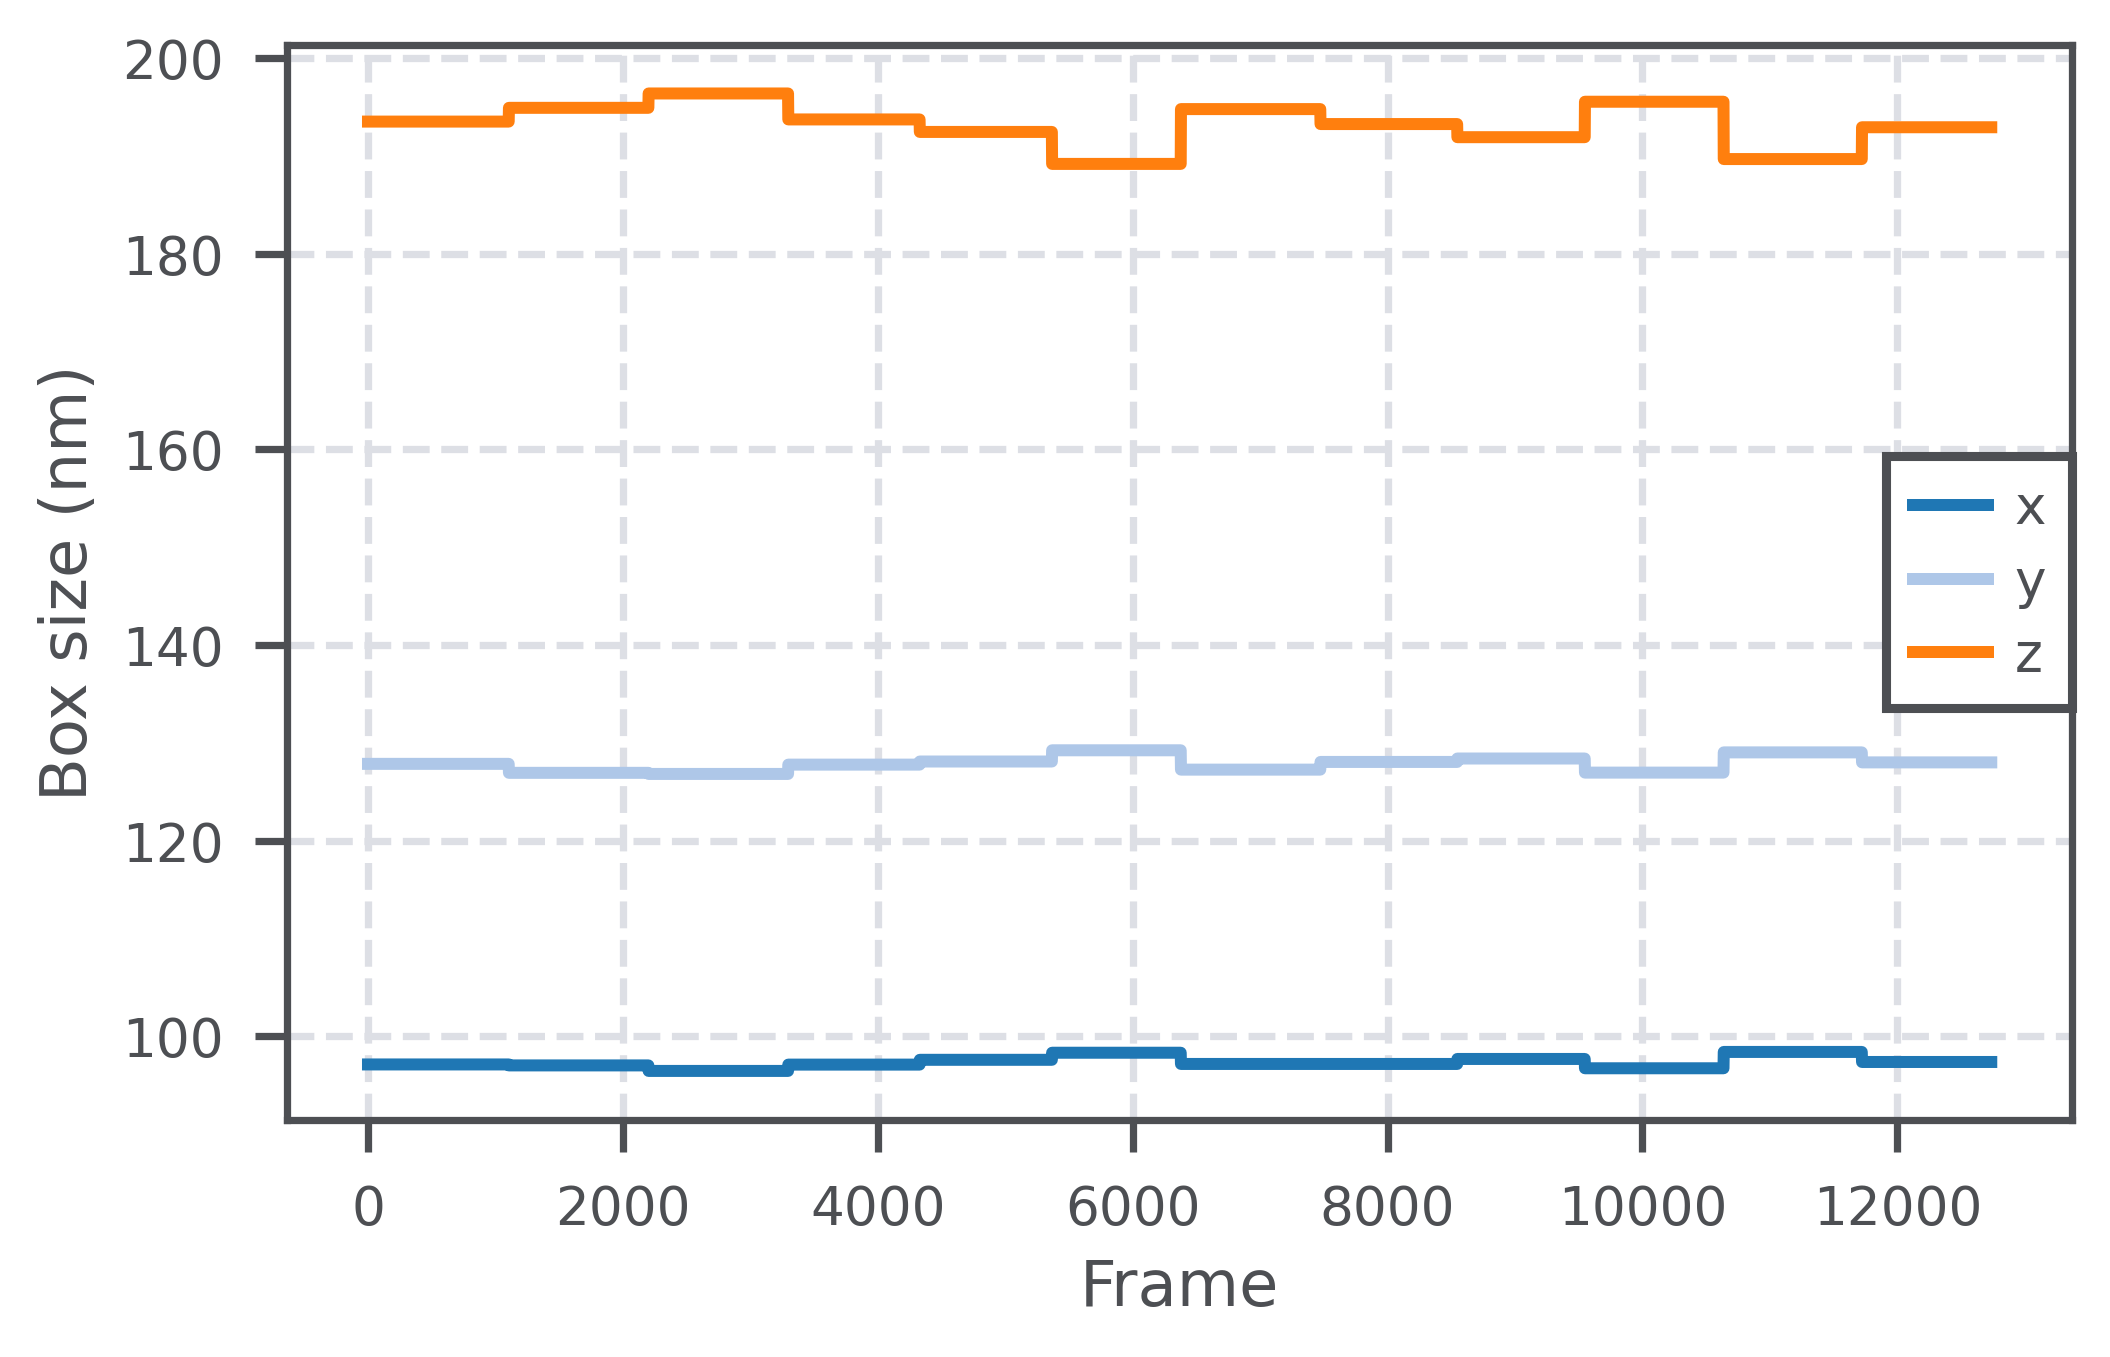

In [33]:
sys_validator.plot_box()

2025-01-10 14:50:24.374 | INFO     | __main__:plot_rmsd:107 - Plotting RMSD


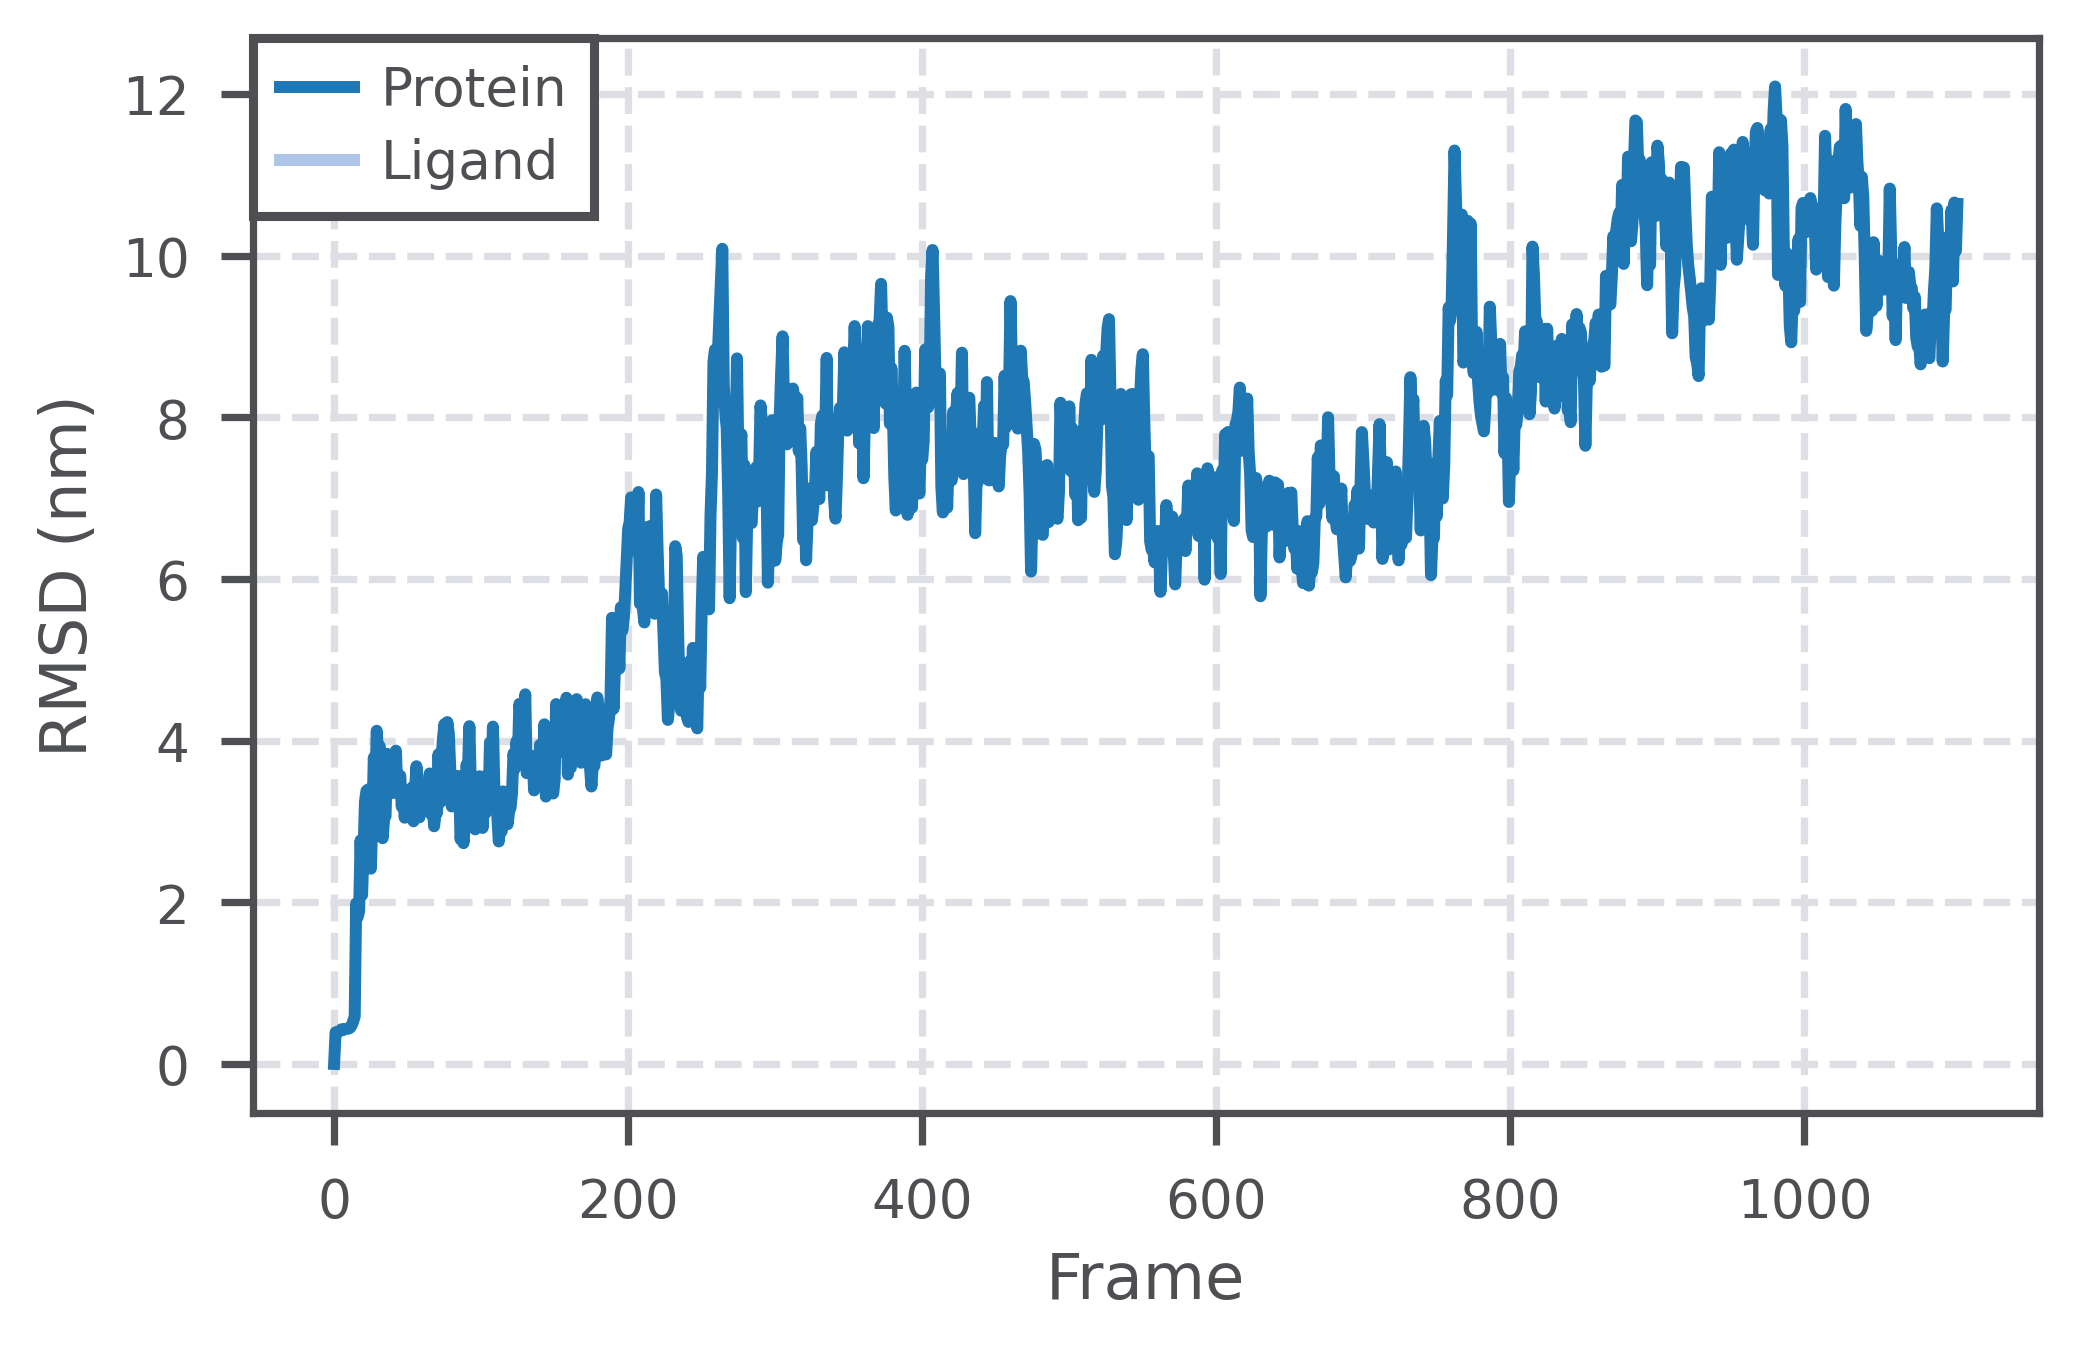

In [28]:
sys_validator.plot_rmsd()

2025-01-10 14:50:30.655 | INFO     | __main__:plot_rmsf:117 - Plotting RMSF


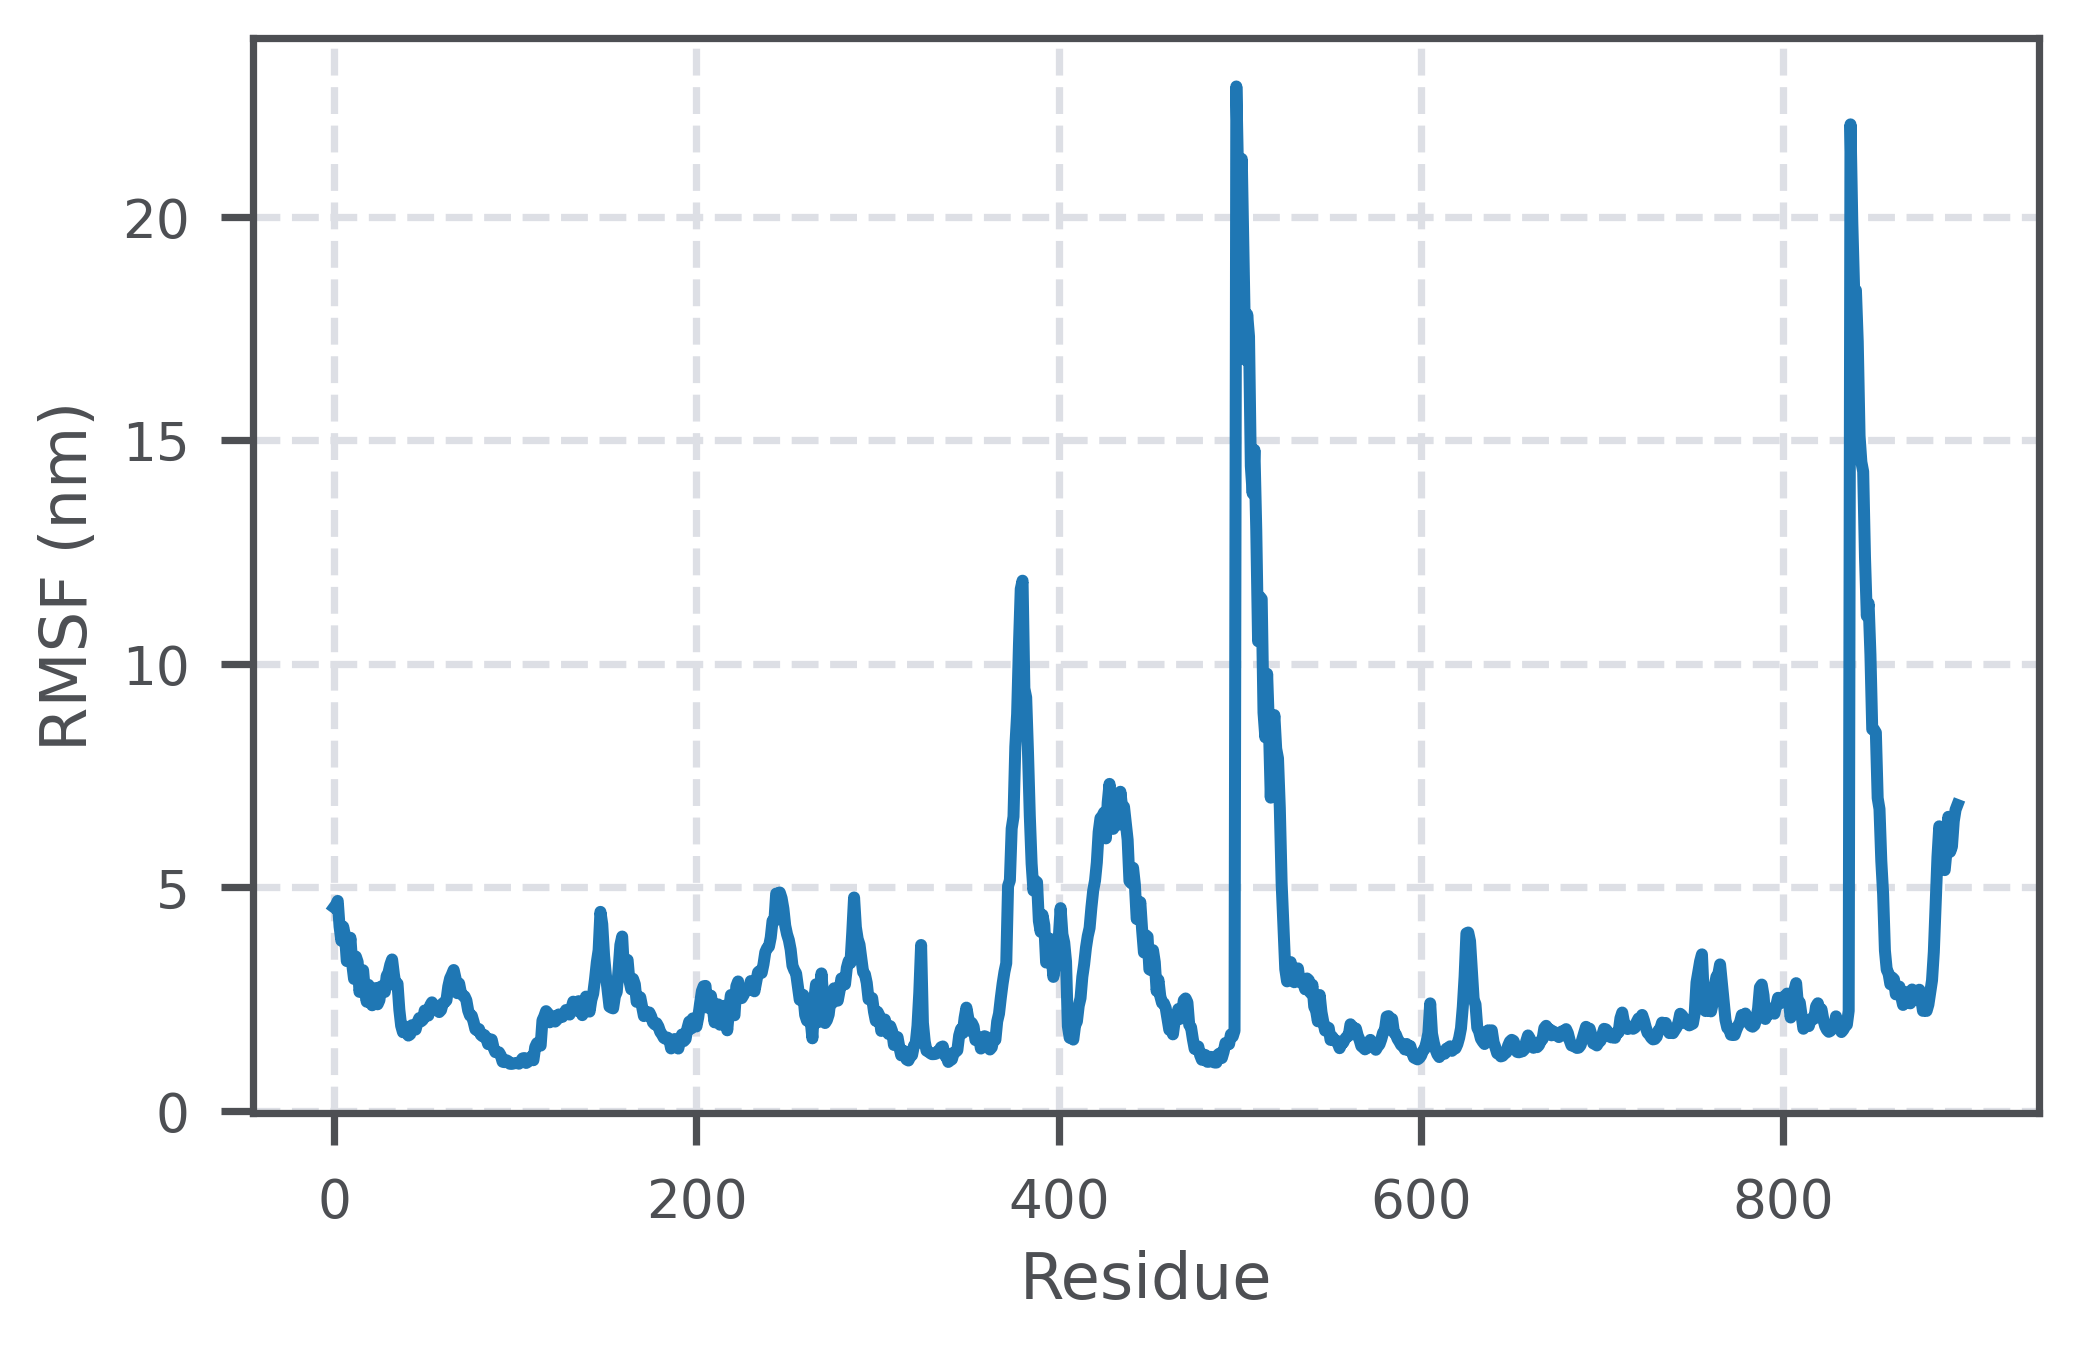

In [29]:
sys_validator.plot_rmsf()

2025-01-10 12:08:52.336 | INFO     | __main__:plot_leaflet_areas:120 - Plotting leaflet areas


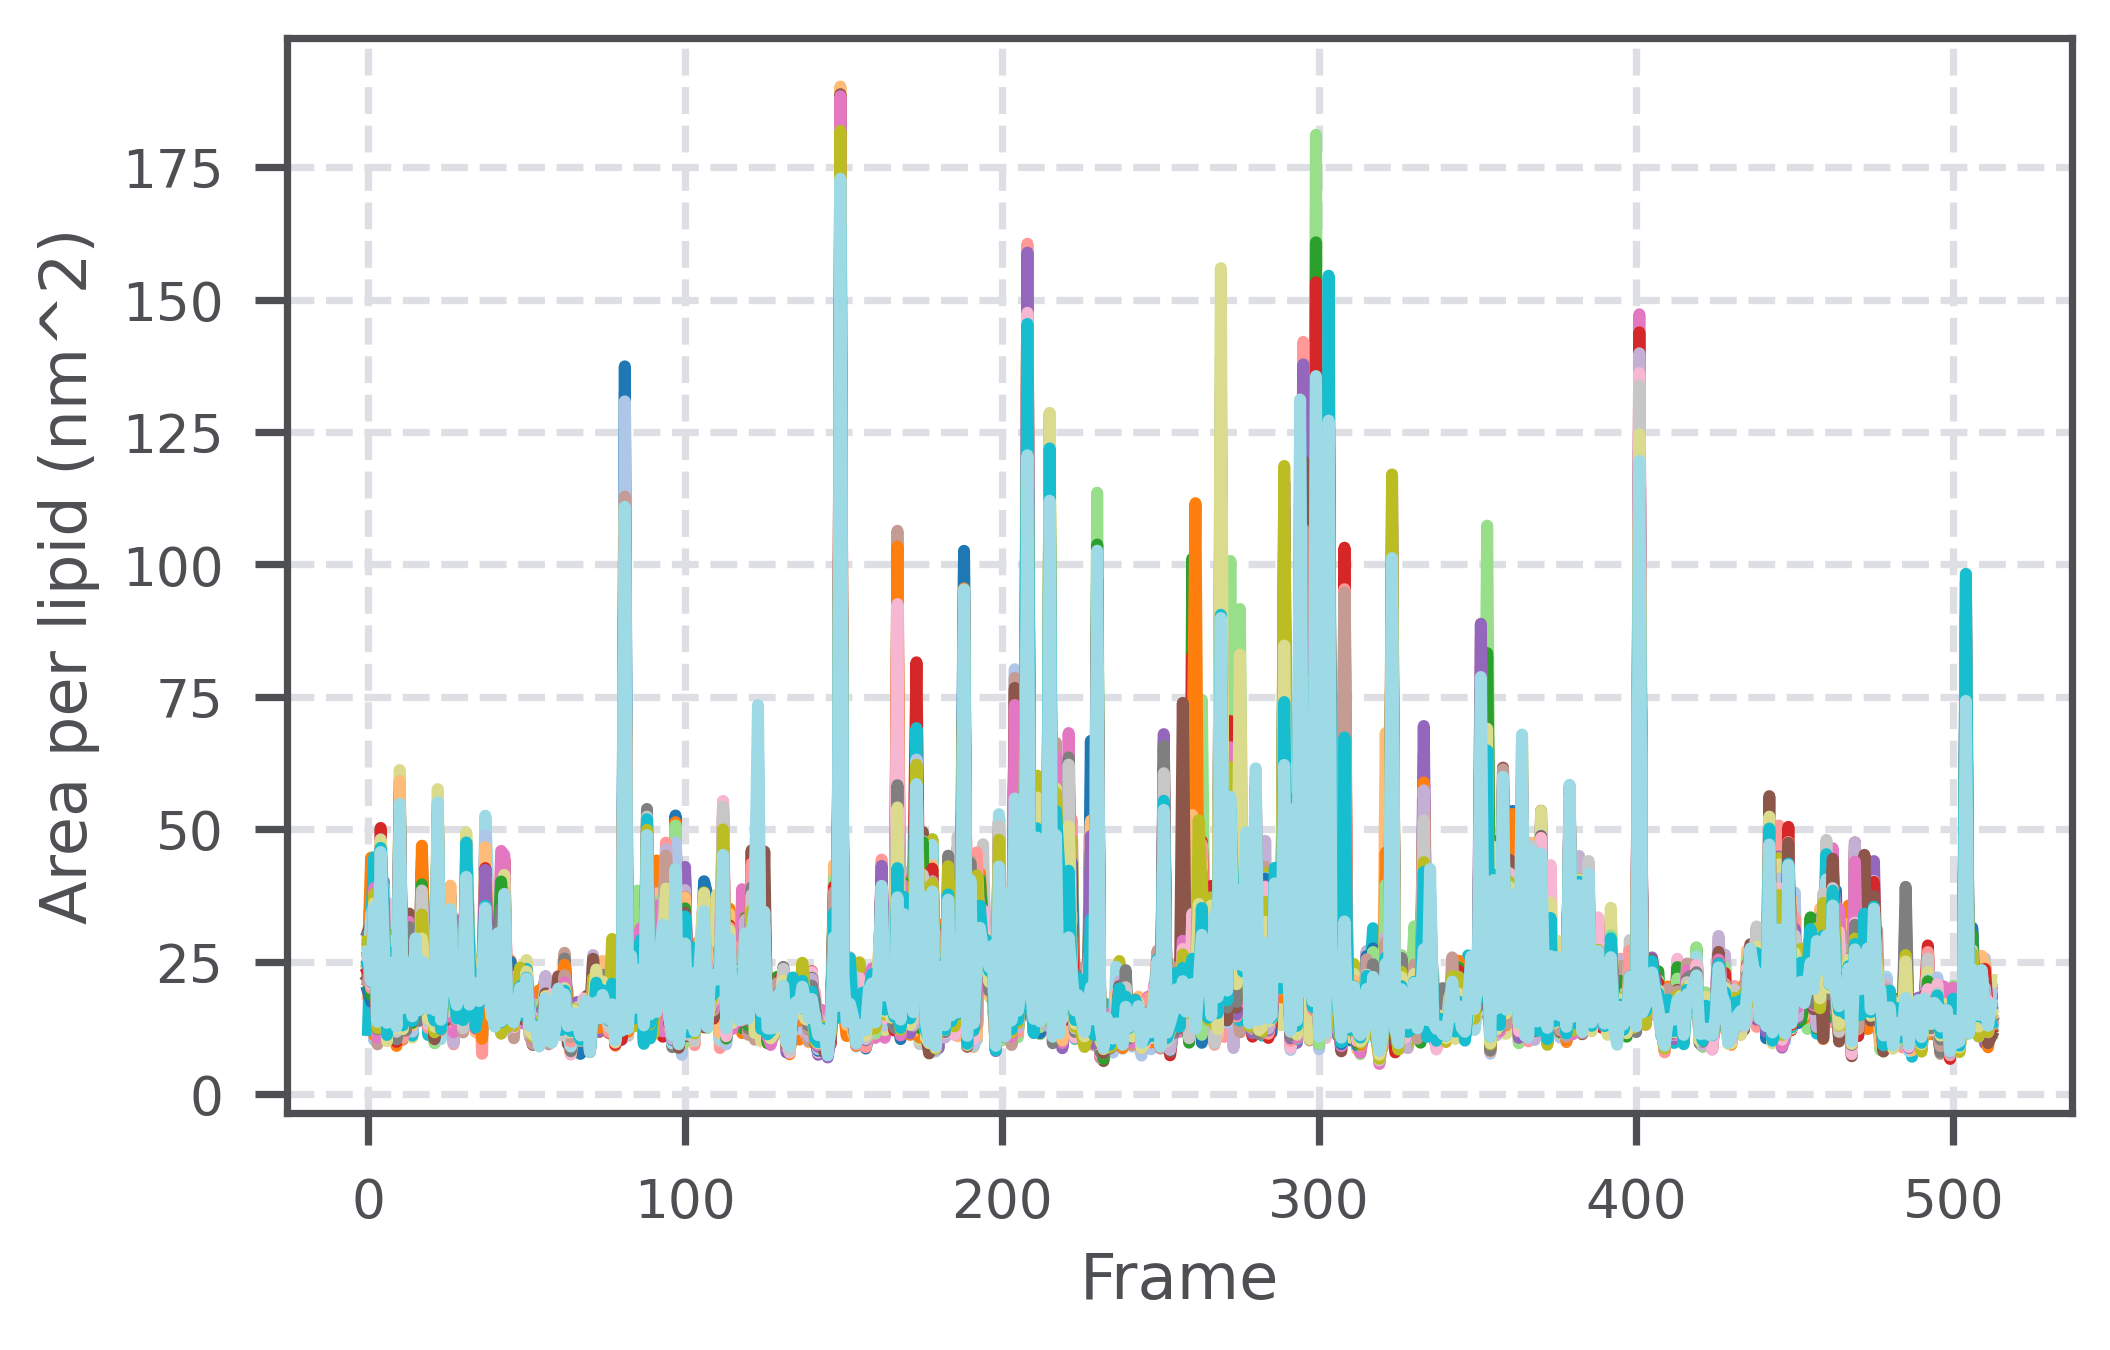

In [11]:
sys_validator.plot_leaflet_areas()

In [13]:
from lipyphilic.plotting.plotting import ProjectionPlot

In [18]:
sys_validator.results['leaflet_areas'].shape

(513, 40)

In [17]:
sys_validator.results['leaflet_areas']
ProjectionPlot(
    x_pos=np.arange(len(sys_validator.results['leaflet_areas'])),
    y_pos=np.zeros(len(sys_validator.results['leaflet_areas'])),
    values=sys_validator.results['leaflet_areas']
).project_values(bins=100)

AttributeError: The number of `values` elements must match the length of each `sample` dimension.